Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - last_time_step_mse: 0.0670 - loss: 0.0706 - val_last_time_step_mse: 0.0400 - val_loss: 0.0454
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - last_time_step_mse: 0.0358 - loss: 0.0426 - val_last_time_step_mse: 0.0316 - val_loss: 0.0388
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - last_time_step_mse: 0.0316 - loss: 0.0361 - val_last_time_step_mse: 0.0306 - val_loss: 0.0365
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - last_time_step_mse: 0.0305 - loss: 0.0350 - val_last_time_step_mse: 0.0316 - val_loss: 0.0355
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - last_time_step_mse: 0.0300 - loss: 0.0343 - val_last_time_step_mse: 0.0291 - val_loss: 0.0348
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - last_time_step_mse: 0.0276 - loss: 0.0328 - val_last_time_step_mse: 0.0276 - val_loss: 0.0350
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - last_time_step_mse: 0.0253 - loss: 0.0314 - v

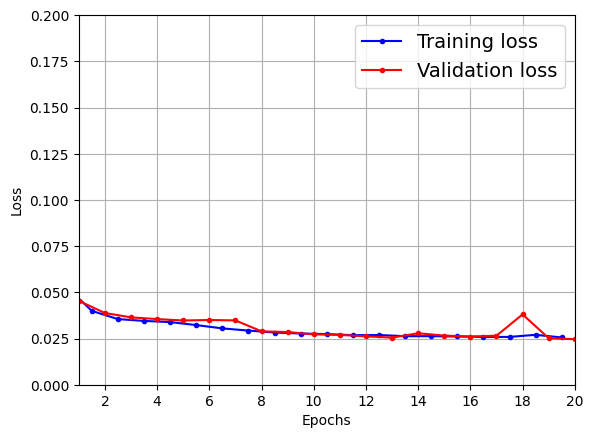

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - last_time_step_mse: 0.0155 - loss: 0.0247
Test loss (MSE for all steps): 0.024685615673661232
Test last time step MSE: 0.014890476129949093
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


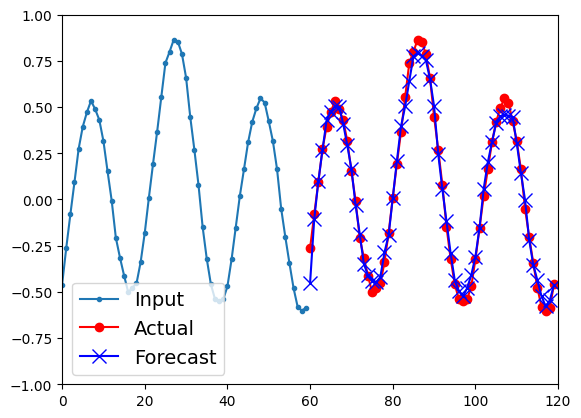

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
series = np.load('univariate-time-series-multi-step.npy')

# Define the number of steps and prepare the dataset
n_steps = 60
X_train = series[:9000, :n_steps]
X_valid = series[9000:11000, :n_steps]
X_test = series[11000:, :n_steps]

# Prepare the target data for sequence-to-sequence forecasting
Y = np.empty((series.shape[0], n_steps, 10))

for step_ahead in range(1, 11):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:9000]
Y_valid = Y[9000:11000]
Y_test = Y[11000:]

# Build the sequence-to-sequence RNN model
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[n_steps, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# Custom metric to calculate MSE only for the last time step
def last_time_step_mse(Y_true, Y_pred):
    return tf.reduce_mean(tf.square(Y_true[:, -1] - Y_pred[:, -1]))

# Compile the model
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

# Plot the learning curves
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

# Evaluate the model on the test set
test_loss, test_last_mse = model.evaluate(X_test, Y_test)
print("Test loss (MSE for all steps):", test_loss)
print("Test last time step MSE:", test_last_mse)

# Make predictions
Y_pred = model.predict(X_test)

# Plot predictions for the first sample in the test set
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plt.plot(X[0, :, 0], ".-", label="Input")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    plt.show()

plot_multiple_forecasts(X_test, Y_test, Y_pred)
